In [401]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))
from typing import List

import time 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import pytorch_lightning as pl

from torch import Tensor, einsum
from einops import parse_shape, rearrange, repeat

np.set_printoptions(precision=3, edgeitems=20, linewidth=250)
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=20, linewidth=250)

def count_parameters(model: nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def count_parameters_all(model: nn.Module):
    return sum(p.numel() for p in model.parameters())

TODO & TOUGHTS:
* Error accumulates with each layer, as expected.
* We can speed up the stages by avoiding decoding (loss on decoded out) and by training stages one after the other such that we don't have to encode multiple times. This might also help with errors as it behaves more like full backprop since there's communication between stages. 
* What I like about this method is that the error signals only travels internally in each block.


In [489]:
class Block(nn.Module):
    
    def __init__(
        self,
        in_channels: int, 
        out_channels: int,
        downscale: bool = False 
    ):
        super().__init__() 
        
        self.encoder = nn.Sequential(
            nn.Conv2d(
                in_channels = in_channels,
                out_channels = out_channels,
                kernel_size = 4 if downscale else 3,
                stride = 2 if downscale else 1,
                padding = 1,
            ),
            nn.ReLU(),
        )
        
        self.decoder = nn.ConvTranspose2d(
            in_channels = out_channels,
            out_channels = in_channels,
            kernel_size = 4 if downscale else 3,
            stride = 2 if downscale else 1,
            padding = 1,
        )
    
    def requires_grad(self, requires_grad):
        for param in self.parameters():
            param.requires_grad = requires_grad
        
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, z):
        return self.decoder(z)
        
    def forward(self, x):
        z = self.encode(x)
        return self.decode(z) 
    
    
class SandwichModel(nn.Module):
    
    def __init__(
        self,
        channels: List[int] = [3, 8, 64, 256],
        downscales: List[bool] = [1, 0, 1]
    ):
        super().__init__() 
        layers = zip(channels[:-1], channels[1:], downscales)
        self.blocks = nn.ModuleList([
            Block(in_channels, out_channels, downscale) 
            for in_channels, out_channels, downscale in layers
        ])
        self.set_stage(0)
        
    def set_stage(self, stage):
        self.stage = stage 
        # Remove grad from all blocks except current 
        for i, block in enumerate(self.blocks):
            block.requires_grad(i == stage)
        
    def reset_current_stage_params(self):
        block = self.blocks[self.stage]
        block.encoder[0].reset_parameters()
        block.decoder.reset_parameters()
        
    def encode(self, x: Tensor) -> Tensor:
        for i in range(self.stage + 1):
            x = self.blocks[i].encode(x)
        return x 
    
    def decode(self, x: Tensor) -> Tensor: 
        for i in reversed(range(self.stage + 1)):
            x = self.blocks[i].decode(x)
        return x
        
    def forward(self, x: Tensor) -> Tensor:
        z = self.encode(x)
        return self.decode(z)
        
arch = SandwichModel()
arch.set_stage(0)
arch.reset_current_stage_params()
for param in arch.blocks[1].parameters():
    print(param.requires_grad)
#arch(torch.rand(1,3,255,255)).shape

False
False
False
False


In [490]:
from brainle.datamodules.image_datamodule import ImageDatamodule 
from brainle.datamodules.transforms.to_float import ToFloat 
    

class Model(pl.LightningModule):
    def __init__(
        self,
        model, 
        lr: float
    ):
        super().__init__()
        self.model = model
        self.lr = lr 

    def configure_optimizers(self):
        filtered_params = filter(lambda p: p.requires_grad, self.model.parameters())
        optimizer = torch.optim.Adam(filtered_params, lr=self.lr)
        return optimizer

    def training_step(self, batch, batch_idx):
        images = batch
        images_pred = self.model(images)
        loss = F.mse_loss(images, images_pred)
        self.log("train_loss", loss, on_step=True)
        return loss
        
datamodule = ImageDatamodule(
    data_dir = "../data/archive.zip",
    train_val_split= [50000, 11214],
    batch_size = 16,
    num_workers = 0,
    transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize(size=128),
        torchvision.transforms.RandomCrop(size=[128, 128]),
        torchvision.transforms.PILToTensor(),
        ToFloat()
    ])
)

arch = SandwichModel(
    channels = [3, 12, 12, 12],
    downscales = [1, 0, 1]
)

# Callbacks 
cb_progress_bar = pl.callbacks.RichProgressBar()
cb_model_summary = pl.callbacks.RichModelSummary()

In [646]:
to_image = torchvision.transforms.ToPILImage()
blur = torchvision.transforms.GaussianBlur((21,21), sigma=(4,4))
sample = next(iter(datamodule.val_dataloader()))  

In [492]:
# Stage 0
arch.set_stage(0)
arch.reset_current_stage_params()
model = Model(arch, lr=0.01) 
trainer = pl.Trainer(callbacks=[cb_progress_bar, cb_model_summary], max_epochs=200)
trainer.fit(model=model, datamodule=datamodule)
# 3 * 128 * 128 = 49152 -> 12 * 64 * 64 = 49152, 0.0000914

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


┏━━━┳━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name  ┃ Type          ┃ Params ┃
┡━━━╇━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model │ SandwichModel │  8.4 K │
└───┴───────┴───────────────┴────────┘

Trainable params: 1.2 K                                                                      
Non-trainable params: 7.2 K                                                                  
Total params: 8.4 K                                                                          
Total estimated model params size (MB): 0

Output()

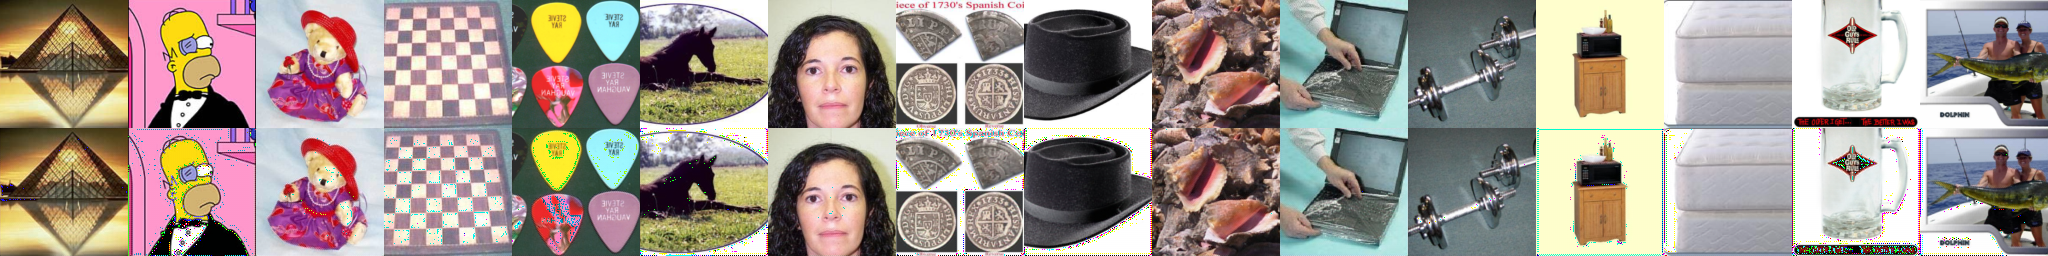

In [642]:
arch.set_stage(0)
grid = rearrange([sample, model.model(sample)], "n b c h w -> c (n h) (b w) ")
to_image(grid)

In [569]:
# Stage 1
arch.set_stage(1)
arch.reset_current_stage_params()
model = Model(arch, lr=0.01) 
trainer = pl.Trainer(callbacks=[cb_progress_bar, cb_model_summary], max_epochs=200)
trainer.fit(model=model, datamodule=datamodule)
# 0.000624

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


┏━━━┳━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name  ┃ Type          ┃ Params ┃
┡━━━╇━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model │ SandwichModel │  8.4 K │
└───┴───────┴───────────────┴────────┘

Trainable params: 2.6 K                                                                      
Non-trainable params: 5.8 K                                                                  
Total params: 8.4 K                                                                          
Total estimated model params size (MB): 0

Output()

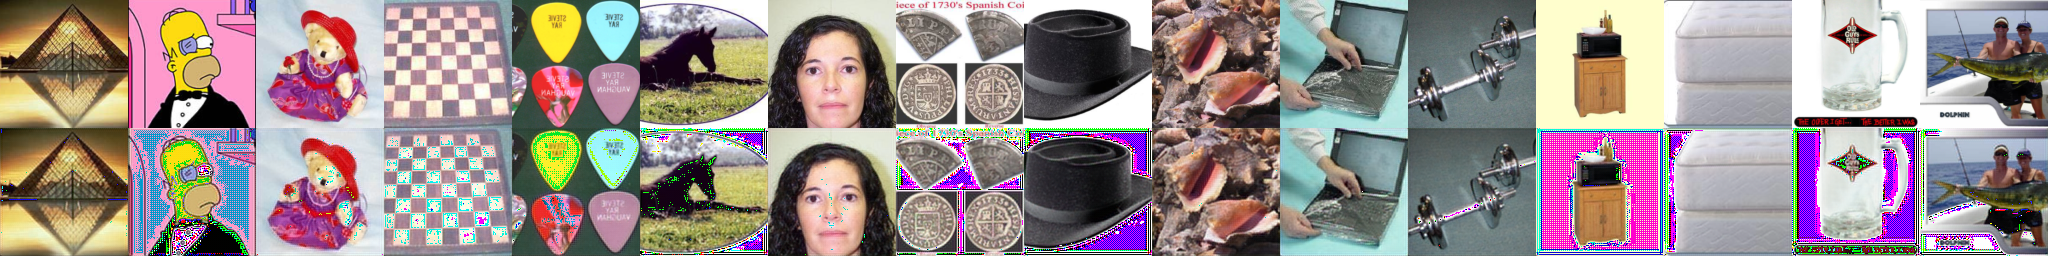

In [643]:
arch.set_stage(1)
grid = rearrange([sample, model.model(sample)], "n b c h w -> c (n h) (b w) ")
to_image(grid)

In [593]:
# Stage 2
arch.set_stage(2)
arch.reset_current_stage_params()
model = Model(arch, lr=0.01) 
trainer = pl.Trainer(callbacks=[cb_progress_bar, cb_model_summary], max_epochs=200)
trainer.fit(model=model, datamodule=datamodule)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


┏━━━┳━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name  ┃ Type          ┃ Params ┃
┡━━━╇━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model │ SandwichModel │  8.4 K │
└───┴───────┴───────────────┴────────┘

Trainable params: 4.6 K                                                                      
Non-trainable params: 3.8 K                                                                  
Total params: 8.4 K                                                                          
Total estimated model params size (MB): 0

Output()

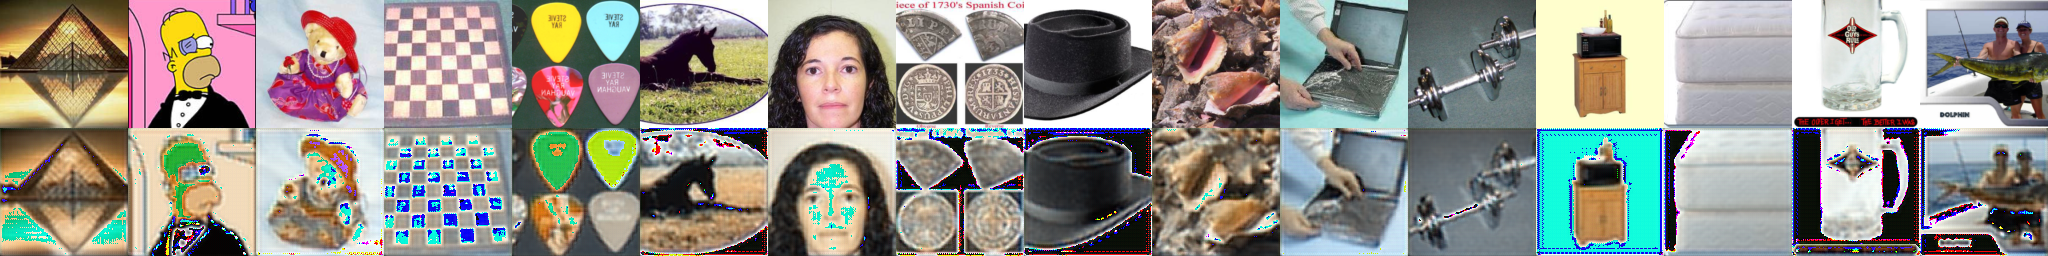

In [644]:
arch.set_stage(2)
grid = rearrange([sample, model.model(sample)], "n b c h w -> c (n h) (b w) ")
to_image(grid)

Output()

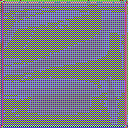

In [649]:
import cv2
from rich.progress import track
from PIL import Image

# Compute gradient of filter wrt to input 

img = sample[0].clone().unsqueeze(0).requires_grad_()#torch.rand((1, 3, 128, 128), requires_grad=True)#
img.requires_grad = True
arch.set_stage(-1) # No grads 
arch.stage = 1
filter_id = 3
steps = 1000
optimizer = torch.optim.Adam([img], lr=0.1, weight_decay=1e-6)

for n in track(range(steps)): 
    optimizer.zero_grad()
    pattern = model.model.encode(img)[0, filter_id]
    loss = - pattern.mean()
    loss.backward()
    optimizer.step()    

to_image(img[0])

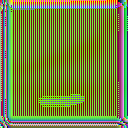

In [650]:
to_image(blur(img[0]))